In [17]:
import pandas as pd
import numpy as np

In [19]:
data=pd.read_csv('D:/python learning\marketmixmodel/Econometric Model for Pie Sales - Raw Data.csv')

In [20]:
data

,Time,"Pie Sales ($1,000s)",Price ($),"Advertising ($1,000s)",Holiday
0,Week 1,350,5.5,3.3,0
1,Week 2,460,7.5,3.3,1
2,Week 3,350,8.0,3.0,0
3,Week 4,430,8.0,4.5,1
4,Week 5,350,6.8,3.0,0
5,Week 6,380,7.5,4.0,0
6,Week 7,430,4.5,3.0,0
7,Week 8,470,6.4,3.7,1
8,Week 9,450,7.0,3.5,1
9,Week 10,490,5.0,4.0,1


In [21]:
data.isnull().sum()

Time                     0
Pie Sales ($1,000s)      0
Price ($)                0
Advertising ($1,000s)    0
Holiday                  0
dtype: int64

In [24]:
#Create a function to clean the data and add a constant

def make_column_as_index(df:pd.DataFrame, column_label:str) -> None:
    df.index = df[column_label]
    df.drop(column_label, axis=1, inplace=True)
    df.index.name = None

def rename_column(df:pd.DataFrame, column_label:str, new_name:str) -> None:
    df.rename(columns={column_label: new_name}, inplace=True)
    
def add_constant(df:pd.DataFrame) -> None:
    df['constant'] = 1

In [25]:
#use the function to clean the data

df = data.copy()

make_column_as_index(df, 'Time')
rename_column(df, 'Pie Sales ($1,000s)', 'sales')
rename_column(df, 'Price ($)', 'price')
rename_column(df, 'Advertising ($1,000s)', 'ads')
rename_column(df, 'Holiday', 'holiday')

add_constant(df)

df.head()


,sales,price,ads,holiday,constant
Week 1,350,5.5,3.3,0,1
Week 2,460,7.5,3.3,1,1
Week 3,350,8.0,3.0,0,1
Week 4,430,8.0,4.5,1,1
Week 5,350,6.8,3.0,0,1


In [38]:
## Run Regression Model -- Define the regression and r2 calculate function

from sklearn.feature_selection import f_regression, RFE
from sklearn.linear_model import LinearRegression
from typing import List, Tuple, Union

def get_all_X_labels(df:pd.DataFrame, y_label:str, date_label:str=None) -> List[str]:
    X_labels = list(df.columns)
    X_labels.remove(y_label)
    if date_label:
        X_labels.remove(date_label)
    
    return X_labels

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from typing import List, Tuple

def run_regression(df:pd.DataFrame, y_label:str, X_labels:List[str]) -> Tuple[np.array, np.array, np.array, np.array]:
    y_actual = df[y_label]
    X_data = df[X_labels]

    results = sm.OLS(y_actual, X_data).fit()

    y_pred = results.predict(X_data)
    coefficients = results.params.values
    p_values = results.pvalues.values

    return y_actual, y_pred, coefficients, p_values


In [37]:
import statsmodels.api as sm

from sklearn import metrics
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from typing import List, Tuple, Union

In [40]:
def calculate_r2(y_actual: Union[np.array, List[float], pd.Series], 
                 y_pred: Union[np.array, List[float], pd.Series]) -> float:
    # r squared score
    return round(metrics.r2_score(y_actual, y_pred),3)

In [41]:
#Running model 

y_label = "sales"
X_labels = get_all_X_labels(df, y_label)

y_actual, y_pred, coefficients, p_values = run_regression(df, y_label, X_labels)

r2 = calculate_r2(y_actual, y_pred)

In [46]:
#Functions to display result

from IPython.display import display

import matplotlib.pyplot as plt

In [43]:
def create_results_df(X_labels:List[str], coefficients:np.array, p_values:List[float]=None) -> pd.DataFrame:
    if p_values is None: # ml algo doesn't give p_values
        results_df = pd.DataFrame({'coefficient': coefficients}, index=X_labels)
    else:
        results_df = pd.DataFrame({'coefficient': coefficients, 'p_value': p_values}, index=X_labels)

    return results_df

In [51]:
def display_accuracy_chart(y_actual:Union[np.array, List[float], pd.Series], 
                           y_pred:Union[np.array, List[float], pd.Series], 
                           y_label:str=None, 
                           accuracy:Tuple[str, str]=None) -> None:
    # set up figure and subplots
    fig, ax = plt.subplots(figsize=(14,8), nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]})
    
    # create plot df
    plot_df = pd.DataFrame()
    plot_df['Actual'] = y_actual
    plot_df['Predicted'] = y_pred
    plot_df['Error'] = (y_pred - y_actual) / y_actual * 100
    
    # plot actual vs predicted on grid
    if y_label:
        plot_df[['Actual', 'Predicted']].plot(ax=ax[0], ylabel=y_label)
    else:
        plot_df[['Actual', 'Predicted']].plot(ax=ax[0])

    if accuracy:
        ax[0].annotate(f'{accuracy[0]} = {accuracy[1]}', xy=(0.05, 0.92), xycoords='axes fraction')

    ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2)
    ax[0].grid(True, which='both')
    
    # plot error on grid
    plot_df[['Error']].plot(ax=ax[1], color='red')
    ax[1].grid(True, which='both')
    ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=2)
    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    
   
    
    # show plots
    fig.autofmt_xdate(rotation=45)
    plt.gcf().suptitle("Actual vs Predicted", fontsize=20)
    
    plt.show()

,coefficient,p_value
price,-17.291705,0.027880
ads,16.337767,0.436946
holiday,89.432562,0.000772
constant,415.098517,0.000153


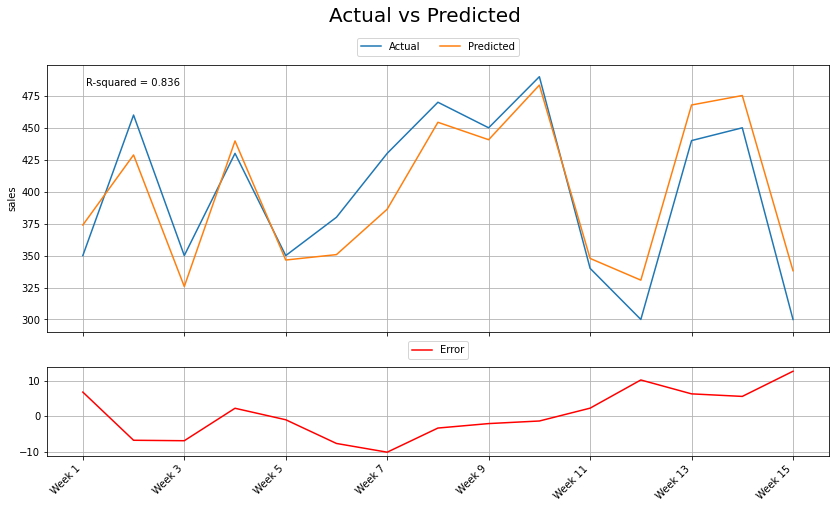

In [52]:
#Calling the function

results_df = create_results_df(X_labels, coefficients, p_values)
display(results_df)

display_accuracy_chart(y_actual, y_pred, y_label, accuracy=("R-squared", r2))

In [ ]:
#Creating ad stock rate - a measurement of the advertising decay effect

In [57]:
import statsmodels.tsa as tsa

def add_adstocks(df:pd.DataFrame, column_label:str, adstock_rates:List[float]=None) -> List:
    if adstock_rates is None:
        adstock_rates = [round(i*0.1,1) for i in range(1,10)]

    added_columns = list()
    for ar in adstock_rates:
        ar_column = f"{column_label} AR={ar}"
        df[ar_column] = tsa.filters.filtertools.recursive_filter(df[column_label], ar)
        added_columns.append(ar_column)
    return added_columns

In [58]:
media_column = "ads"
adstock_columns = add_adstocks(df, media_column, adstock_rates=[0.15])
df.head()

,sales,price,ads,holiday,constant,ads AR=0.15
Week 1,350,5.5,3.3,0,1,3.300000
Week 2,460,7.5,3.3,1,1,3.795000
Week 3,350,8.0,3.0,0,1,3.569250
Week 4,430,8.0,4.5,1,1,5.035387
Week 5,350,6.8,3.0,0,1,3.755308


In [59]:
#Changing the X and Y variables and performing regression including the adstock variable

def add_X_labels(X_labels, add_cols):
    for x in add_cols:
        if x not in X_labels:
            X_labels.append(x)

    return X_labels

def del_X_labels(X_labels:List[str], del_cols:List[str]) -> List[str]:
    for x in del_cols:
        if x in X_labels:
            X_labels.remove(x)

    return X_labels

In [60]:
X_labels = del_X_labels(X_labels, [media_column])
X_labels = add_X_labels(X_labels, adstock_columns)
X_labels

['price', 'holiday', 'constant', 'ads AR=0.15']

,coefficient,p_value
price,-17.710259,0.024434
holiday,87.418204,0.000883
constant,399.115569,0.000372
ads AR=0.15,18.877213,0.354514


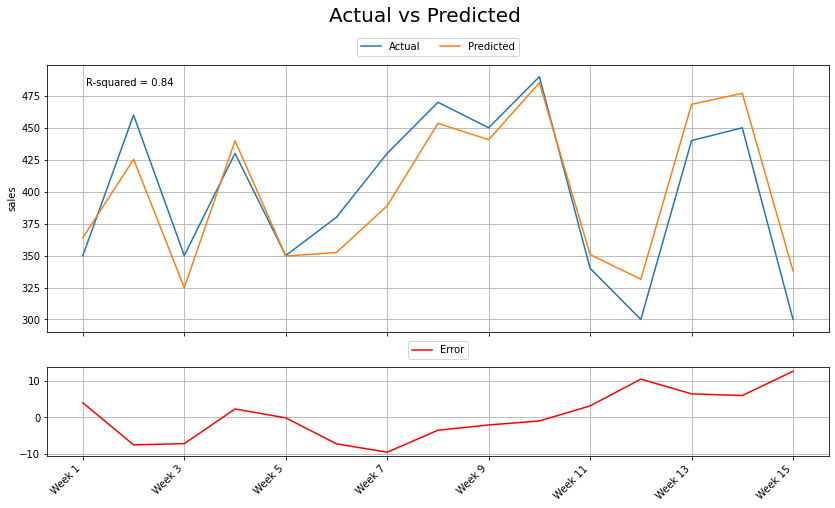

In [61]:
# Run model with adstocked ads

y_actual, y_pred, coefficients, p_values = run_regression(df, y_label, X_labels)

r2 = calculate_r2(y_actual, y_pred)

results_df = create_results_df(X_labels, coefficients, p_values)
display(results_df)

display_accuracy_chart(y_actual, y_pred, y_label, accuracy=("R-squared", r2))


In [ ]:
#The r2 value is more when Ad stock is included in the model, thereby getting us a more accurate model. Using the Coefficents,intercept and X variables we will be able to predict the values of sales for the given X inputs